<a href="https://colab.research.google.com/github/Hjjooo/-/blob/main/%EC%A1%B0%ED%98%9C%EC%A7%84/kospi200_%EC%9E%AC%EB%AC%B4%EC%A0%9C%ED%91%9C_%ED%81%AC%EB%A1%A4%EB%A7%81_%EB%B0%8F_EDA_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%82%B0%EC%97%85%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykrx

In [ ]:
pip install dart-fss

In [ ]:
!pip install opendartreader

**dart 재무제표 크롤링**

앞서 받은 merged_kospi_200_corp_list.csv 와 OpenDartReader를 활용하여 200개 기업의 2020~2024 분기별 재무제표를 크롤링한다.

dart.finstate 함수로는 재무상태표, 손익계산서의 간단한 지표만 불러올 수 있음

In [ ]:
import OpenDartReader
import pandas as pd

# KOSPI 기업 코드 목록 불러오기
kospi_200_list = pd.read_csv('./merged_kospi_200_corp_list.csv')

# Dart API 설정
api_key = '0728a6d81b70b86763fd38daafcc1fccff0beedb' # Dart API 키를 입력하세요
dart = OpenDartReader(api_key)

# 기간 및 보고서 코드 설정
start_date = '2020-01-01'  # 시작 날짜
end_date = '2024-11-15'    # 종료 날짜
start_year = int(start_date.split('-')[0])  # 시작 연도 추출
end_year = int(end_date.split('-')[0])      # 종료 연도 추출
reprt_codes = ['11013', '11012', '11014', '11011']  # 1분기, 반기, 3분기, 사업보고서 코드

# 최종 데이터를 저장할 빈 데이터프레임 생성
final_df = pd.DataFrame()

# KOSPI 기업 목록을 순회하며 재무 데이터 수집
for index, row in kospi_200_list.iterrows():
    corp_code = str(row['corp_code']).zfill(8)  # 기업 코드를 문자열로 변환하고 8자리로 맞춤
    corp_name = row['corp_name']  # 기업 이름

    # 연도 및 보고서 코드별로 데이터 수집
    for year in range(start_year, end_year + 1):
        for reprt_code in reprt_codes:
            try:
                # 우선 연결재무제표 가져오기 시도
                finstate_df = dart.finstate(corp_code, bsns_year=year, reprt_code=reprt_code)

                # 연결재무제표가 없으면 개별재무제표로 대체
                if finstate_df is None or finstate_df.empty:
                    print(f"{corp_name} ({year} {reprt_code}): 연결재무제표 데이터가 없습니다. 개별재무제표로 대체.")
                    finstate_df = dart.finstate(corp_code, bsns_year=year, reprt_code=reprt_code, fs_div='CFS')  # 개별재무제표 코드

                # 여전히 None인 경우 건너뜀
                if finstate_df is None or finstate_df.empty:
                    print(f"{corp_name} ({year} {reprt_code}): 재무제표 데이터가 없습니다.")
                    continue

                # 데이터프레임에 기업 코드 및 이름 추가
                finstate_df['corp_code'] = corp_code
                finstate_df['corp_name'] = corp_name

                # 데이터가 비어있지 않으면 final_df에 추가
                print(f"{corp_name} ({year} {reprt_code}): 데이터 수집 성공.")
                final_df = pd.concat([final_df, finstate_df], ignore_index=True)
            except Exception as e:
                print(f"에러 발생 - {corp_name} ({year}, {reprt_code}): {e}")

# 최종 데이터 출력 및 저장
print(final_df)
final_df.to_csv('kospi_200_financial_statements.csv', index=False, encoding='utf-8-sig')

**EDA**

In [ ]:
import pandas as pd

# 데이터셋 로드
financial_data = pd.read_csv('kospi_200_financial_statements.csv')

# 기본 정보 출력 및 결측값 확인
print(financial_data.info())
print(financial_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90942 entries, 0 to 90941
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rcept_no           90942 non-null  int64 
 1   reprt_code         90942 non-null  int64 
 2   bsns_year          90942 non-null  int64 
 3   corp_code          90942 non-null  int64 
 4   corp_name          90942 non-null  object
 5   stock_code         90942 non-null  int64 
 6   fs_div             90942 non-null  object
 7   fs_nm              90942 non-null  object
 8   sj_div             90942 non-null  object
 9   sj_nm              90942 non-null  object
 10  account_nm         90942 non-null  object
 11  thstrm_nm          90942 non-null  object
 12  thstrm_dt          90942 non-null  object
 13  thstrm_amount      90942 non-null  object
 14  frmtrm_nm          90620 non-null  object
 15  frmtrm_dt          90620 non-null  object
 16  frmtrm_amount      90942 non-null  objec

In [ ]:
# 기술 통계
print(financial_data.describe())

# 각 열의 고유값 확인
print(financial_data.nunique())


           rcept_no   reprt_code     bsns_year     corp_code     stock_code  \
count  9.094200e+04  90942.00000  90942.000000  9.094200e+04   90942.000000   
mean   2.022245e+13  11012.52230   2021.940819  3.872313e+05   71970.177366   
std    1.360143e+10      1.08093      1.352667  3.951650e+05  101773.397629   
min    2.020051e+13  11011.00000   2020.000000  1.028580e+05      80.000000   
25%    2.021081e+13  11012.00000   2021.000000  1.265660e+05    5930.000000   
50%    2.022082e+13  11013.00000   2022.000000  1.616930e+05   23530.000000   
75%    2.023111e+13  11013.00000   2023.000000  5.265990e+05   90430.000000   
max    2.024111e+13  11014.00000   2024.000000  1.762569e+06  457190.000000   

                ord  
count  90942.000000  
mean      19.997823  
std       16.400801  
min        1.000000  
25%        8.000000  
50%       17.000000  
75%       26.000000  
max       70.000000  
rcept_no              3242
reprt_code               4
bsns_year                5
corp_code

rcept_no 의 특성을 이용하여 공시날짜열을 생성


In [ ]:
# rcept_no를 문자열로 변환 후 왼쪽 8자 추출하여 날짜로 변환
financial_data['listing_date'] = pd.to_datetime(financial_data['rcept_no'].astype(str).str[:8], format='%Y%m%d')

# 결과 확인
print(financial_data[['rcept_no', 'listing_date']])

# 업데이트된 파일 저장
financial_data.to_csv('updated_kospi_200_financial_statements.csv', index=False, encoding='utf-8-sig')

# 데이터셋 로드
financial_data = pd.read_csv('updated_kospi_200_financial_statements.csv')

             rcept_no listing_date
0      20200515000867   2020-05-15
1      20200515000867   2020-05-15
2      20200515000867   2020-05-15
3      20200515000867   2020-05-15
4      20200515000867   2020-05-15
...               ...          ...
90937  20240814002991   2024-08-14
90938  20240814002991   2024-08-14
90939  20240814002991   2024-08-14
90940  20240814002991   2024-08-14
90941  20240814002991   2024-08-14

[90942 rows x 2 columns]


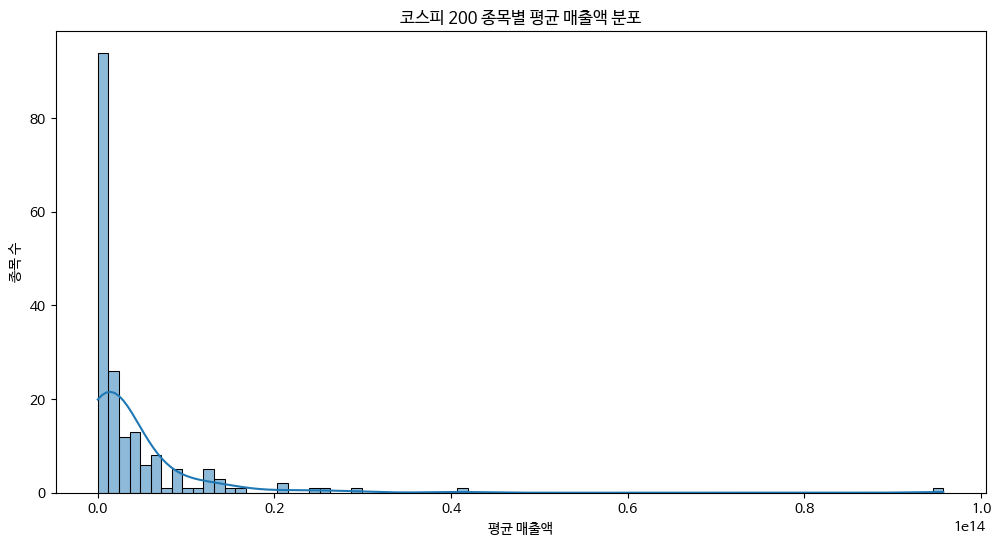

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# '-' 값을 NaN으로 변환
financial_data['thstrm_amount'] = financial_data['thstrm_amount'].replace('-', np.nan)

# 모든 값을 문자열로 변환한 후 쉼표 제거, 숫자로 변환
financial_data['thstrm_amount'] = financial_data['thstrm_amount'].astype(str).str.replace(',', '').astype(float)

# 예시로 매출액의 평균값을 각 종목별로 계산하여 시각화
avg_revenue = financial_data[financial_data['account_nm'] == '매출액'].groupby('stock_code')['thstrm_amount'].mean()

# 시각화
plt.figure(figsize=(12, 6))
sns.histplot(avg_revenue, kde=True)
plt.title('코스피 200 종목별 평균 매출액 분포')
plt.xlabel('평균 매출액')
plt.ylabel('종목 수')
plt.show()



**상위/하위 종목들만 시각화**

> 인용구 추가



특정 지표에 대해 상위 10개 또는 하위 10개 종목만 선택하여 시각화하는 방법이다.예를 들어, 매출액 상위 10개 종목과 하위 10개 종목의 분포를 확인할 수 있다.


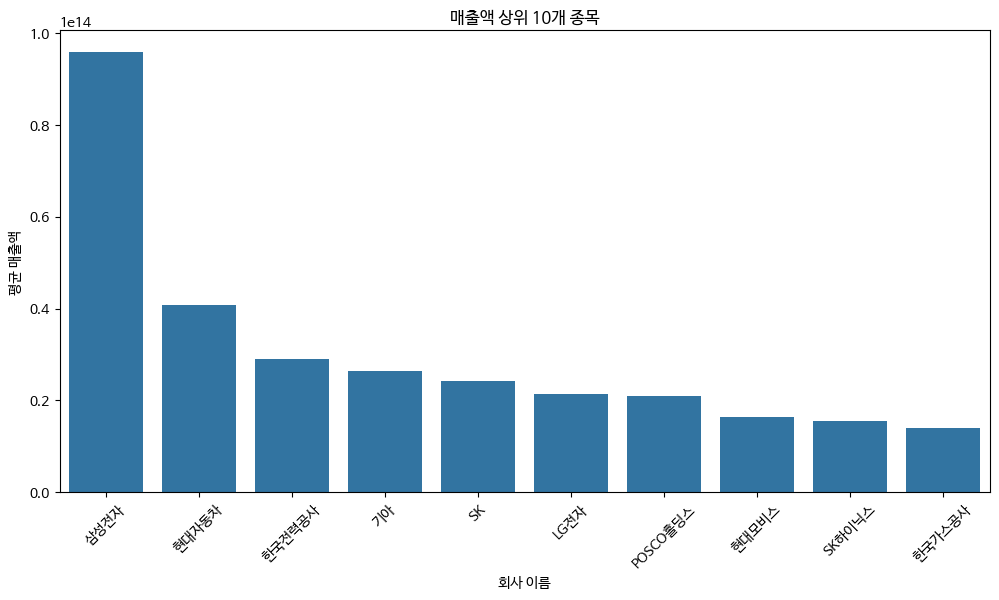

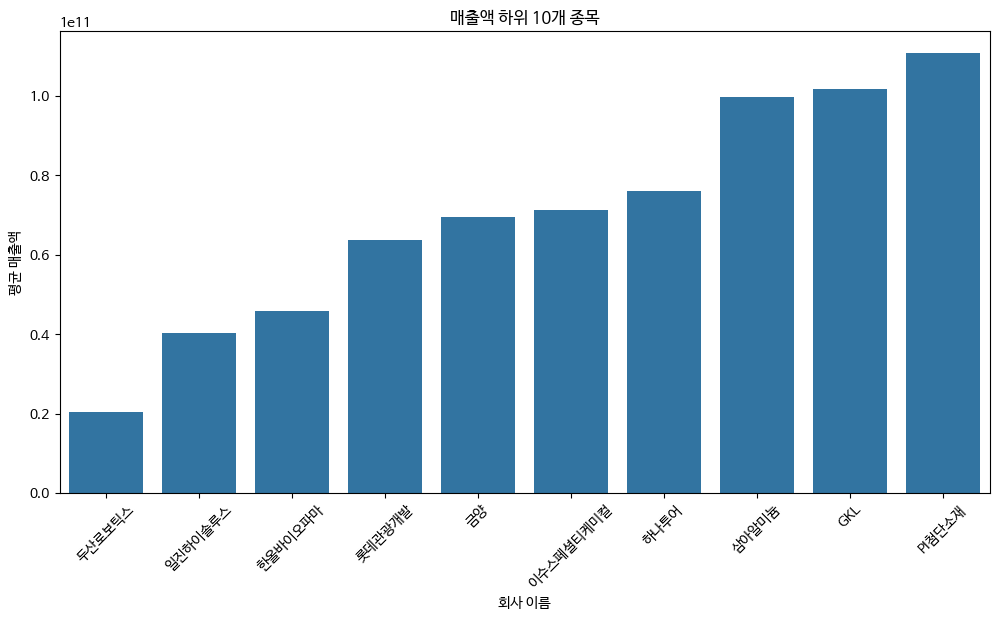

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# stock_code와 corp_name 간의 매핑 딕셔너리 생성
stock_to_name = financial_data[['stock_code', 'corp_name']].drop_duplicates().set_index('stock_code')['corp_name'].to_dict()

# 매출액 상위 10개 종목 추출
top10_revenue = financial_data[financial_data['account_nm'] == '매출액'].groupby('stock_code')['thstrm_amount'].mean().nlargest(10)
# 매출액 하위 10개 종목 추출
bottom10_revenue = financial_data[financial_data['account_nm'] == '매출액'].groupby('stock_code')['thstrm_amount'].mean().nsmallest(10)

# 상위 10개와 하위 10개의 stock_code를 회사 이름으로 변환
top10_revenue.index = top10_revenue.index.map(stock_to_name)
bottom10_revenue.index = bottom10_revenue.index.map(stock_to_name)

# 매출액 상위 10개 종목 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_revenue.index, y=top10_revenue.values)
plt.title('매출액 상위 10개 종목')
plt.xlabel('회사 이름')
plt.ylabel('평균 매출액')
plt.xticks(rotation=45)
plt.show()

# 매출액 하위 10개 종목 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=bottom10_revenue.index, y=bottom10_revenue.values)
plt.title('매출액 하위 10개 종목')
plt.xlabel('회사 이름')
plt.ylabel('평균 매출액')
plt.xticks(rotation=45)
plt.show()


**클러스터링으로 그룹화**

200개의 종목을 유사한 재무 지표를 기준으로 클러스터링하여 그룹화한 뒤, 각 그룹의 평균값이나 분포를 시각화할 수 있다. 이는 k-평균 클러스터링과 같은 방법을 사용하여 그룹을 나눈 후 분석하는 방법이다.


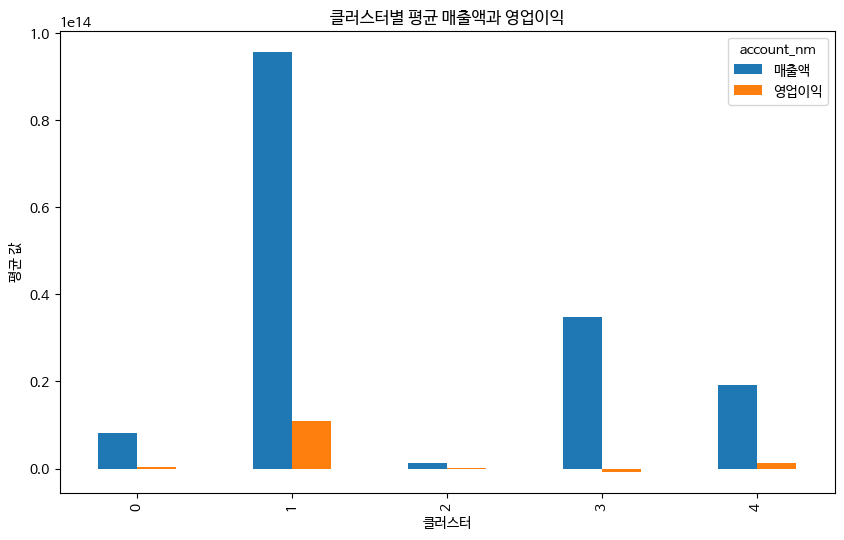

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# 예시: 매출액과 영업이익을 클러스터링에 사용할 특성으로 선택
features = financial_data[financial_data['account_nm'].isin(['매출액', '영업이익'])].pivot_table(index=
                                                                                          'stock_code', columns='account_nm', values='thstrm_amount', aggfunc='mean').fillna(0)

# KMeans로 클러스터링 (예: 5개의 클러스터로 그룹화)
kmeans = KMeans(n_clusters=5, random_state=42)
features['Cluster'] = kmeans.fit_predict(features)

# 클러스터별 평균 매출액, 영업이익 시각화
cluster_summary = features.groupby('Cluster').mean()
cluster_summary.plot(kind='bar', figsize=(10, 6))
plt.title('클러스터별 평균 매출액과 영업이익')
plt.xlabel('클러스터')
plt.ylabel('평균 값')
plt.show()


In [ ]:
# stock_code와 corp_name을 병합하여 각 클러스터에 포함된 기업명 확인
features_with_names = features.copy()
features_with_names['corp_name'] = features_with_names.index.map(stock_to_name)  # stock_code를 corp_name으로 변환
features_with_names = features_with_names.reset_index()

# 각 클러스터별 기업 출력
for cluster_num in sorted(features_with_names['Cluster'].unique()):
    cluster_companies = features_with_names[features_with_names['Cluster'] == cluster_num][['corp_name', 'Cluster']]
    print(f"클러스터 {cluster_num}에 포함된 기업들:")
    print(cluster_companies['corp_name'].values)
    print("\n")


클러스터 0에 포함된 기업들:
['두산' '현대건설' '한화' 'CJ' '대한항공' '현대제철' 'LS' '삼성SDI' '미래에셋증권' 'S-Oil' 'LG이노텍'
 '롯데케미칼' 'HMM' 'SK텔레콤' '롯데쇼핑' '삼성물산' '케이티' 'LG유플러스' 'LG디스플레이' '포스코인터내셔널'
 '한국금융지주' 'GS' '현대글로비스' 'SK이노베이션' 'CJ제일제당' '메리츠금융지주' '이마트' 'HD현대'
 'LG에너지솔루션']


클러스터 1에 포함된 기업들:
['삼성전자']


클러스터 2에 포함된 기업들:
['하이트진로' '유한양행' 'CJ대한통운' 'DL' '한국앤컴퍼니' '영풍' '삼성화재해상보험' 'LX인터내셔널' '세아베스틸지주'
 '대한전선' '금양' '대상' 'SK네트웍스' '오리온홀딩스' '케이씨씨' 'TCC스틸' '아모레퍼시픽그룹' '세아제강지주'
 '대웅' '삼양식품' 'LG' 'KG모빌리티' '포스코퓨처엠' '롯데정밀화학' '신세계' '농심' '세방전지' '효성' '롯데지주'
 '코스모신소재' '녹십자홀딩스' '롯데칠성음료' '코스모화학' '에스엘' '삼아알미늄' '녹십자' 'GS건설' '대한유화'
 'GS리테일' '오뚜기' '율촌화학' '호텔신라' '한미사이언스' '삼성전기' '한샘' '한올바이오파마' 'HD한국조선해양'
 '한화솔루션' '명신산업' '영원무역홀딩스' 'OCI홀딩스' '엘에스일렉트릭' '고려아연' '삼성중공업' 'HD현대미포'
 '현대위아' '금호석유화학' 'SKC' '한화에어로스페이스' '에스원' '한솔케미칼' '동원시스템즈' 'KG스틸' '현대엘리베이터'
 '삼성에스디에스' '한온시스템' '코웨이' '포스코DX' '동서' '삼성E&A' '팬오션' '삼성카드' '제일기획' '롯데관광개발'
 '케이티앤지' '두산에너빌리티' '강원랜드' 'NAVER' '카카오' '엔씨소프트' '하나투어' '키움증권' '한화오션'
 'HD현대인프라코어' '한미반도체' '대우건설' '한국항공우주' '한전KPS' 'LG생활건강' '한전기술

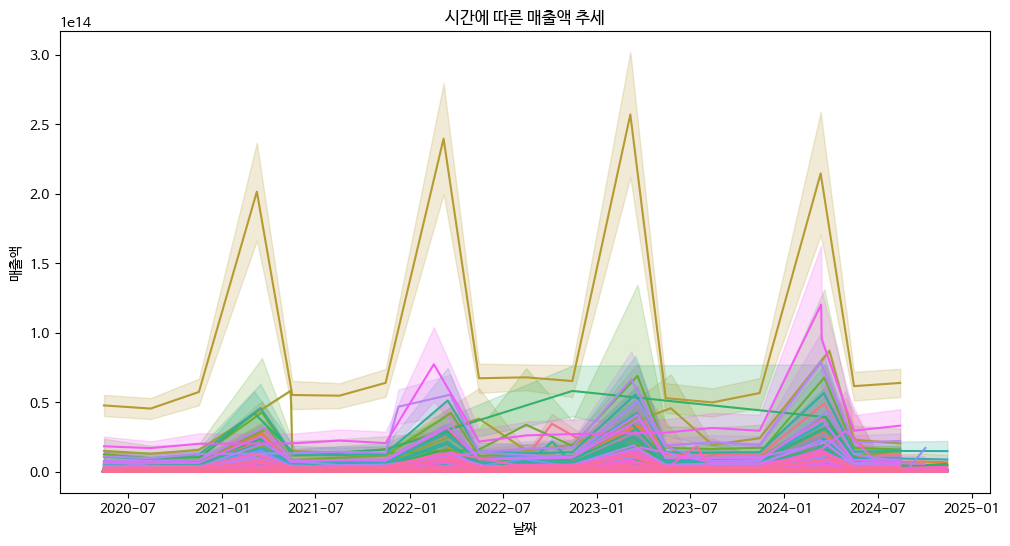

In [ ]:
# 'date' 열이 날짜 형식이 아니라면 datetime 형식으로 변환
financial_data['listing_date'] = pd.to_datetime(financial_data['listing_date'])

# 예시: 매출액의 시간에 따른 추세
revenue_data = financial_data[financial_data['account_nm'] == '매출액']

# 시간에 따른 매출액 추세 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='listing_date', y='thstrm_amount', hue='corp_name', data=revenue_data, legend=None)
plt.title('시간에 따른 매출액 추세')
plt.xlabel('날짜')
plt.ylabel('매출액')
plt.show()


**시간에 따른 주요 지표의 변화 추이**

기업별로 listing_date에 따라 매출액, 영업이익, 자산총계 등의 지표가 어떻게 변화했는지를 시계열 그래프로 시각화할 수 있다. 상위 몇 개 기업만 선택하여 시각화하면 데이터를 더 잘 이해할 수 있다.

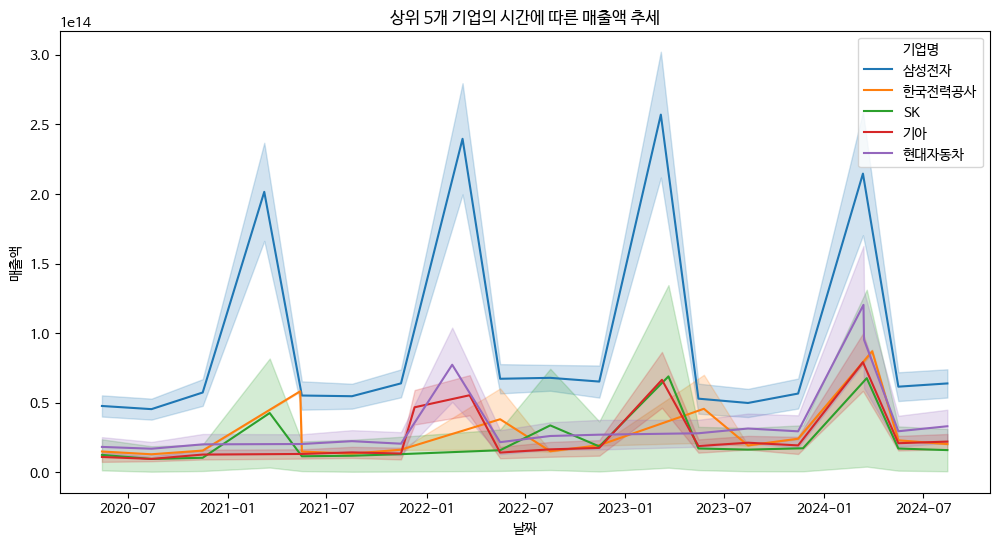

In [ ]:
# 시간에 따른 매출액 추세 시각화 (상위 5개 기업)
financial_data['listing_date'] = pd.to_datetime(financial_data['listing_date'])

top_companies = financial_data[financial_data['account_nm'] == '매출액'].groupby('corp_name')['thstrm_amount'].sum().nlargest(5).index
filtered_data = financial_data[financial_data['corp_name'].isin(top_companies) & (financial_data['account_nm'] == '매출액')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='listing_date', y='thstrm_amount', hue='corp_name', data=filtered_data)
plt.title('상위 5개 기업의 시간에 따른 매출액 추세')
plt.xlabel('날짜')
plt.ylabel('매출액')
plt.legend(title='기업명')
plt.show()


**상관 분석 및 재무 지표 간 관계 탐색**

각 재무 지표 간의 상관관계를 분석하여, 예를 들어 매출액과 영업이익 또는 자산총계와 부채총계 간의 관계를 파악할 수 있다.

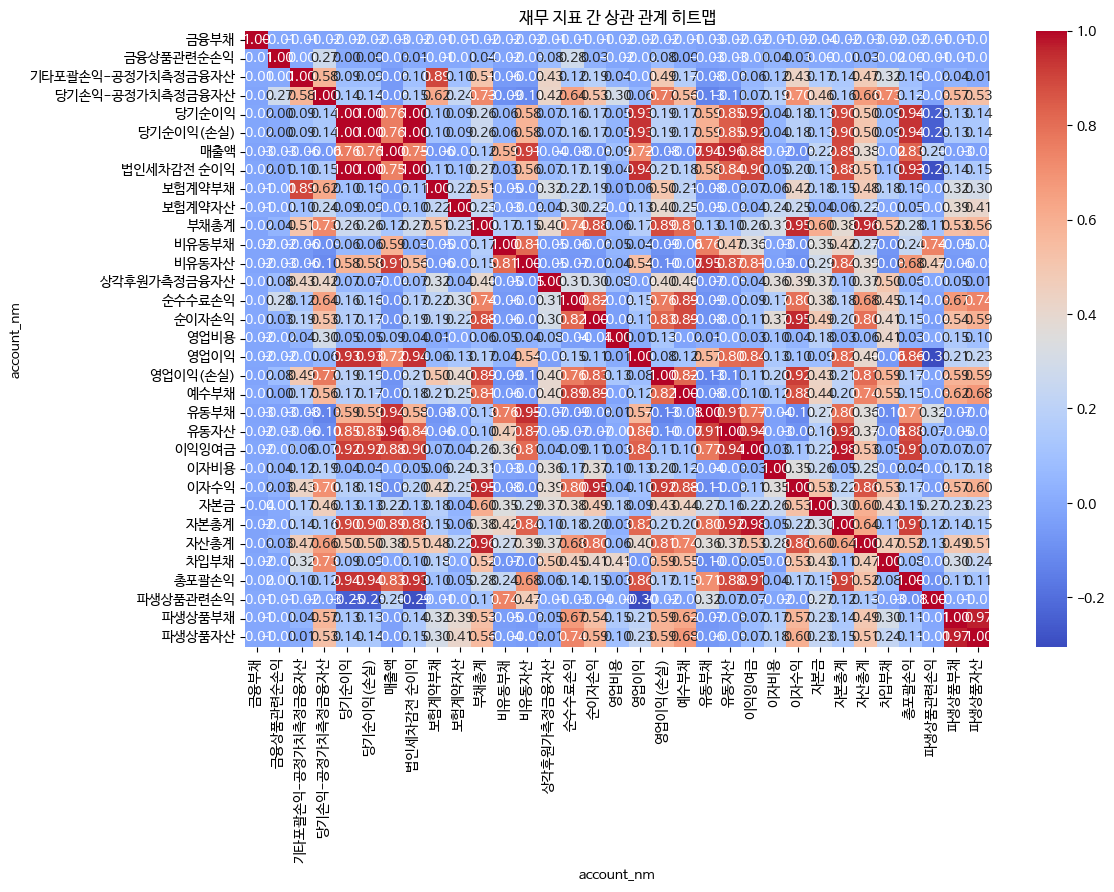

In [ ]:
# 피벗 테이블 생성 (기업별로 주요 지표 열로 변환)
pivot_data = financial_data.pivot_table(index='corp_name', columns='account_nm', values='thstrm_amount', aggfunc='mean').fillna(0)

# 상관 행렬 계산
corr_matrix = pivot_data.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('재무 지표 간 상관 관계 히트맵')
plt.show()


**주가 데이터와 연동하여 분석**

주가 데이터와 연동하여 재무 지표와 주가의 상관관계를 분석하거나, 재무 데이터와 주가 변동을 결합하여 주가 예측 모델을 구축할 수 있다.


In [ ]:
from pykrx import stock
import pandas as pd
import time

# 종목 코드 불러오기 및 6자리로 맞추기
kospi_200_df = pd.read_csv('merged_kospi_200_corp_list.csv')
kospi_200_df['stock_code'] = kospi_200_df['stock_code'].astype(str).str.zfill(6)  # 6자리로 맞추기
kospi_200_codes = kospi_200_df['stock_code'].unique()

# 시작 및 종료 날짜 설정
start_date = '2020-01-01'
end_date = '2024-11-14'

# 빈 데이터프레임 생성
all_stock_data = pd.DataFrame()

# 각 종목에 대해 주가 데이터 가져오기
for ticker in kospi_200_codes:
    try:
        # 주가 데이터 가져오기
        df_stock = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)

        # 주가 데이터에 종목 코드 추가
        df_stock['stock_code'] = ticker

        # 데이터를 병합
        all_stock_data = pd.concat([all_stock_data, df_stock])

        print(f"{ticker} 데이터 수집 완료")
    except Exception as e:
        print(f"{ticker} 데이터 수집 중 오류 발생: {e}")

    # 요청 간의 짧은 대기 시간 추가 (API 서버에 부담을 줄이기 위함)
    time.sleep(0.1)

# 날짜 열을 인덱스에서 컬럼으로 변환
all_stock_data = all_stock_data.reset_index()

# 데이터 확인
print(all_stock_data.head())

# 데이터를 CSV 파일로 저장
all_stock_data.to_csv('kospi_200_stock_data.csv', index=False, encoding='utf-8-sig')


012330 데이터 수집 완료
112610 데이터 수집 완료
003090 데이터 수집 완료
272210 데이터 수집 완료
042660 데이터 수집 완료
489790 데이터 수집 완료
105630 데이터 수집 완료
047050 데이터 수집 완료
298050 데이터 수집 완료
352820 데이터 수집 완료
009830 데이터 수집 완료
001740 데이터 수집 완료
011790 데이터 수집 완료
402340 데이터 수집 완료
375500 데이터 수집 완료
039490 데이터 수집 완료
000880 데이터 수집 완료
068270 데이터 수집 완료
145720 데이터 수집 완료
002380 데이터 수집 완료
207940 데이터 수집 완료
302440 데이터 수집 완료
161390 데이터 수집 완료
073240 데이터 수집 완료
007310 데이터 수집 완료
003230 데이터 수집 완료
280360 데이터 수집 완료
001680 데이터 수집 완료
004370 데이터 수집 완료
271560 데이터 수집 완료
097950 데이터 수집 완료
128940 데이터 수집 완료
185750 데이터 수집 완료
006280 데이터 수집 완료
009420 데이터 수집 완료
024110 데이터 수집 완료
005930 데이터 수집 완료
004000 데이터 수집 완료
008930 데이터 수집 완료
003620 데이터 수집 완료
010130 데이터 수집 완료
180640 데이터 수집 완료
010060 데이터 수집 완료
015760 데이터 수집 완료
028050 데이터 수집 완료
010620 데이터 수집 완료
001440 데이터 수집 완료
009540 데이터 수집 완료
006360 데이터 수집 완료
033780 데이터 수집 완료
069620 데이터 수집 완료
454910 데이터 수집 완료
096770 데이터 수집 완료
139480 데이터 수집 완료
139130 데이터 수집 완료
251270 데이터 수집 완료
192820 데이터 수집 완료
035720 데이터 수집 완료
036570 데이터 수집 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
stock_data = pd.read_csv('kospi_200_stock_data.csv')
stock_data['날짜'] = pd.to_datetime(stock_data['날짜'])  # 날짜 형식 변환


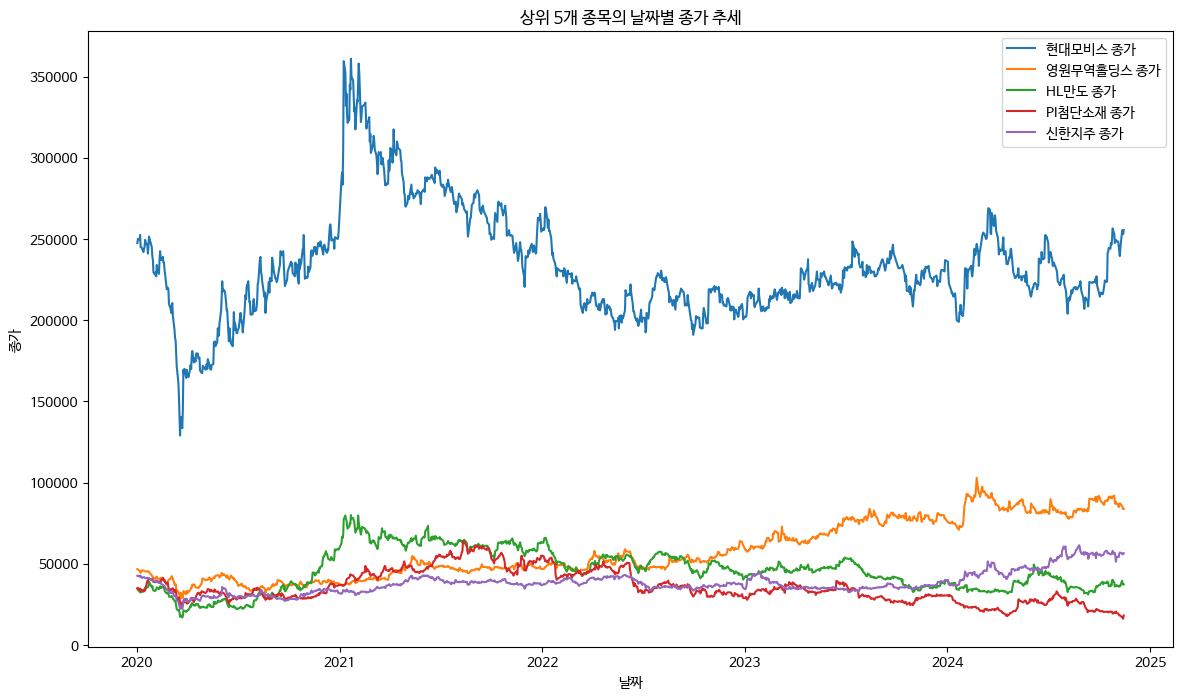

In [ ]:
# 상위 5개 종목 선택
top_5_tickers = stock_data['stock_code'].value_counts().index[:5]
top_5_stocks = stock_data[stock_data['stock_code'].isin(top_5_tickers)]

# 각 종목 코드에 해당하는 종목 이름을 가져오기
corp_names = top_5_stocks[['stock_code', 'corp_name']].drop_duplicates().set_index('stock_code')['corp_name'].to_dict()

# 종가 시각화
plt.figure(figsize=(14, 8))
for ticker in top_5_tickers:
    data = top_5_stocks[top_5_stocks['stock_code'] == ticker]
    corp_name = corp_names.get(ticker, ticker)  # 종목 이름이 없을 경우 코드로 표시
    plt.plot(data['날짜'], data['종가'], label=f'{corp_name} 종가')

plt.title('상위 5개 종목의 날짜별 종가 추세')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


In [ ]:
# 주가 데이터 로드
stock_data = pd.read_csv('kospi_200_stock_data.csv')
stock_data['날짜'] = pd.to_datetime(stock_data['날짜'])

# 재무 데이터 로드
financial_data = pd.read_csv('kospi_200_financial_statements.csv')

# rcept_no에서 공시 날짜 추출하여 listing_date로 변환 (datetime 형식으로 변환)
financial_data['listing_date'] = pd.to_datetime(financial_data['rcept_no'].astype(str).str[:8], format='%Y%m%d')

# 날짜 형식 확인
print(stock_data['날짜'].dtype)  # datetime64[ns]
print(financial_data['listing_date'].dtype)  # datetime64[ns]로 출력되어야 함

# 두 데이터를 병합 (공시 날짜와 주가 날짜 기준으로 병합)
merged_data = pd.merge(stock_data, financial_data, left_on=['날짜', 'stock_code'], right_on=['listing_date', 'stock_code'], how='inner')

# 결과 확인
print(merged_data.head())



datetime64[ns]
datetime64[ns]
          날짜      시가      고가      저가      종가     거래량       등락률  stock_code  \
0 2020-05-15  171000  172500  169000  172500  211529  1.769912       12330   
1 2020-05-15  171000  172500  169000  172500  211529  1.769912       12330   
2 2020-05-15  171000  172500  169000  172500  211529  1.769912       12330   
3 2020-05-15  171000  172500  169000  172500  211529  1.769912       12330   
4 2020-05-15  171000  172500  169000  172500  211529  1.769912       12330   

  corp_name_x        rcept_no  ...      frmtrm_dt       frmtrm_amount  ord  \
0       현대모비스  20200515000867  ...  2019.12.31 현재  21,504,648,000,000    1   
1       현대모비스  20200515000867  ...  2019.12.31 현재  25,101,416,000,000    3   
2       현대모비스  20200515000867  ...  2019.12.31 현재  46,606,064,000,000    5   
3       현대모비스  20200515000867  ...  2019.12.31 현재   8,962,268,000,000    7   
4       현대모비스  20200515000867  ...  2019.12.31 현재   5,234,174,000,000    9   

  currency thstrm_add_amount frm

In [ ]:
# 'account_nm'을 기준으로 피벗 테이블 생성
#financial_pivot = merged_data.pivot_table(
 #   index=['corp_name_x' , 'stock_code', '날짜'],  # 기업명, 종목 코드, 날짜를 인덱스로 설정
  #  columns='account_nm',                      # account_nm의 각 항목을 열로 설정
   # values='thstrm_amount',                    # 값으로 사용할 열
   # aggfunc='first'                            # 첫 번째 값 사용 (여기서 각 분기별 데이터가 있다고 가정)
#).reset_index()

# 열 이름을 깔끔하게 만듦
#financial_pivot.columns.name = None

# 숫자형으로 변환 (문자열로 인식된 경우)
#for column in ['매출액', '영업이익', '부채총계', '자산총계']:
 #   financial_pivot[column] = pd.to_numeric(financial_pivot[column], errors='coerce')

# 파생 변수 생성
#financial_pivot['매출액_증가율'] = financial_pivot.groupby(['corp_name_x', 'stock_code'])['매출액'].pct_change(fill_method=None)
#financial_pivot['영업이익률'] = financial_pivot['영업이익'] / financial_pivot['매출액']
#financial_pivot['자산_부채비율'] = financial_pivot['부채총계'] / financial_pivot['자산총계']

# 결측값 처리
#financial_pivot = financial_pivot.fillna(0)

# 결과 확인
#print(financial_pivot.head())

import pandas as pd
import numpy as np

# 피벗 테이블 생성
financial_pivot = merged_data.pivot_table(
    index=['corp_name_x', 'stock_code', '날짜'],  # 기업명, 종목 코드, 날짜를 인덱스로 설정
    columns='account_nm',                       # account_nm의 각 항목을 열로 설정
    values='thstrm_amount',                     # 값으로 사용할 열
    aggfunc='first'                             # 첫 번째 값 사용
).reset_index()

# 열 이름을 깔끔하게 만듦
financial_pivot.columns.name = None

# 숫자형으로 변환해야 할 열들
numeric_columns = ['매출액', '영업이익', '부채총계', '자산총계','당기순이익', '자본총계']

# 콤마와 공백을 제거하고 숫자형으로 변환 (변환할 수 없는 값은 NaN으로 처리)
for column in numeric_columns:
    financial_pivot[column] = financial_pivot[column].replace({',': '', ' ': ''}, regex=True)  # 콤마와 공백 제거
    financial_pivot[column] = pd.to_numeric(financial_pivot[column], errors='coerce')  # 숫자로 변환

# 파생 변수 생성
# 그룹화하여 매출액 증가율, 영업이익률, 자산 부채비율 계산
financial_pivot['매출액_증가율'] = financial_pivot.groupby(['corp_name_x', 'stock_code'])['매출액'].pct_change(fill_method=None)
financial_pivot['영업이익률'] = (financial_pivot['영업이익'] / financial_pivot['매출액']) * 100
financial_pivot['자산_부채비율'] = (financial_pivot['부채총계'] / financial_pivot['자산총계']) * 100
financial_pivot['ROE'] = (financial_pivot['당기순이익'] / financial_pivot['자본총계']) * 100  # ROE 계산

# 결측값 처리
financial_pivot = financial_pivot.fillna(0)

# 결과 확인
print(financial_pivot[['corp_name_x', 'stock_code', '날짜', '매출액', '영업이익', '부채총계', '자산총계', '매출액_증가율', '영업이익률', '자산_부채비율','ROE']].head())


  corp_name_x  stock_code         날짜           매출액          영업이익  \
0      BGF리테일      282330 2020-05-15  1.393052e+12  1.847880e+10   
1      BGF리테일      282330 2020-08-14  1.549208e+12  4.456064e+10   
2      BGF리테일      282330 2020-11-16  1.682728e+12  6.361129e+10   
3      BGF리테일      282330 2021-03-17  6.181269e+12  1.622042e+11   
4      BGF리테일      282330 2021-05-17  1.501236e+12  2.163136e+10   

            부채총계           자산총계   매출액_증가율     영업이익률    자산_부채비율        ROE  
0  1591177783149  2178886669285  0.000000  1.326497  73.027102   2.042992  
1  1626271198512  2247013118394  0.112096  2.876349  72.374798   5.323177  
2  1775447686421  2447613742031  0.086186  3.780247  72.537903   7.661451  
3  1674341687928  2371169598247  2.673361  2.624125  70.612481  17.609982  
4  1749936310886  2421059916105 -0.757131  1.440904  72.279761   2.364892  


In [ ]:
# 주가 데이터에서 필요한 열만 선택
price_data = stock_data[['날짜', 'stock_code', '종가']]

# financial_pivot과 price_data를 '날짜'와 'stock_code' 기준으로 병합하여 '종가' 열 추가
model_data = pd.merge(financial_pivot, price_data, on=['날짜', 'stock_code'], how='left')

# 설명 변수(X)와 목표 변수(y) 설정
features = ['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율']
X = model_data[features]
y = model_data['종가']  # 목표 변수 설정

# 학습 데이터와 테스트 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 확인
print(X_train.head())
print(y_train.head())



               매출액          영업이익            자산총계            부채총계   매출액_증가율  \
859   2.275336e+13  7.039595e+11  67791074283000  43795903240000  0.143080   
2595  5.146007e+11  2.298584e+10   4833323147598   3554550801687 -0.286406   
809   1.382808e+11  6.118967e+10   2094066245378    406364738271  0.587768   
2496  6.574133e+11  5.696847e+10   3528179419277   2379323406232  0.014802   
2530  2.439243e+11  6.638983e+10   4041485908925    309425351150  0.054331   

          영업이익률    자산_부채비율  
859    3.093870  64.604232  
2595   4.466733  73.542585  
809   44.250291  19.405534  
2496   8.665549  67.437710  
2530  27.217393   7.656227  
859     177111
2595     23900
809     129500
2496     27400
2530     17350
Name: 종가, dtype: int64


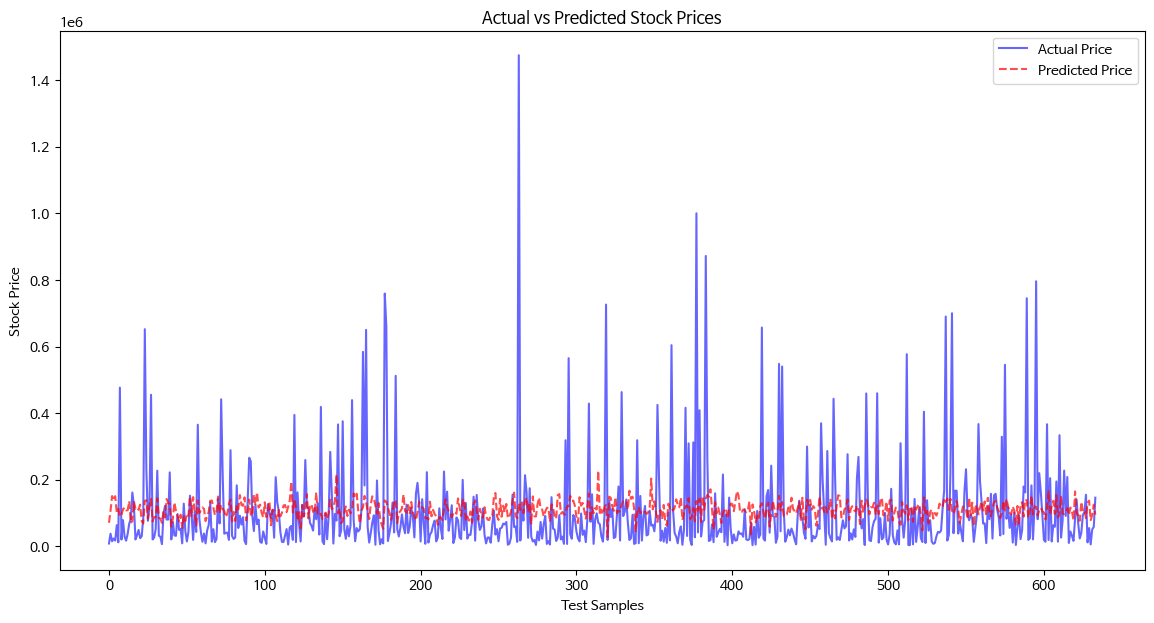

Root Mean Squared Error: 144671.88419534484


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 예측 결과와 실제 주가 비교
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label="Actual Price", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Test Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# RMSE (Root Mean Squared Error) 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


**데이터 정규화 및 비선형 모델 (예: 랜덤 포레스트) 사용 예시**


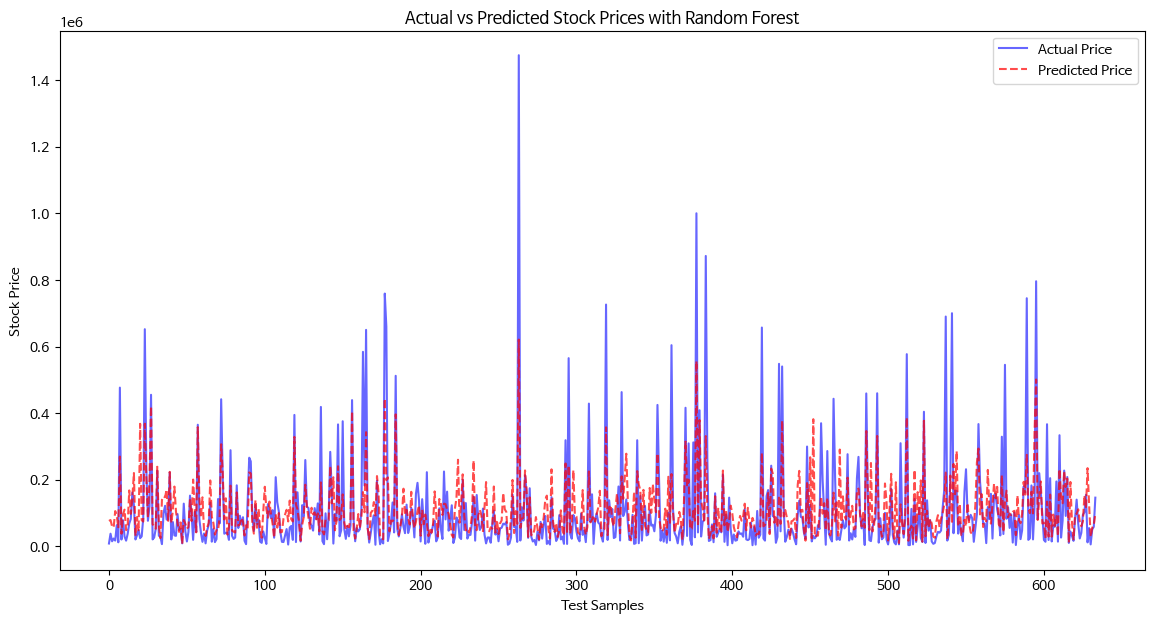

Root Mean Squared Error: 104011.6794270969


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 파이프라인 설정: 데이터 정규화 및 랜덤 포레스트 모델 사용
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 정규화
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # 랜덤 포레스트 회귀 모델
])

# 모델 학습
pipeline.fit(X_train, y_train)

# 예측
y_pred = pipeline.predict(X_test)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label="Actual Price", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices with Random Forest")
plt.xlabel("Test Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


<ipython-input-109-e0645759be06>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['매출액', '영업이익']] = scaler.fit_transform(X[['매출액', '영업이익']])


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


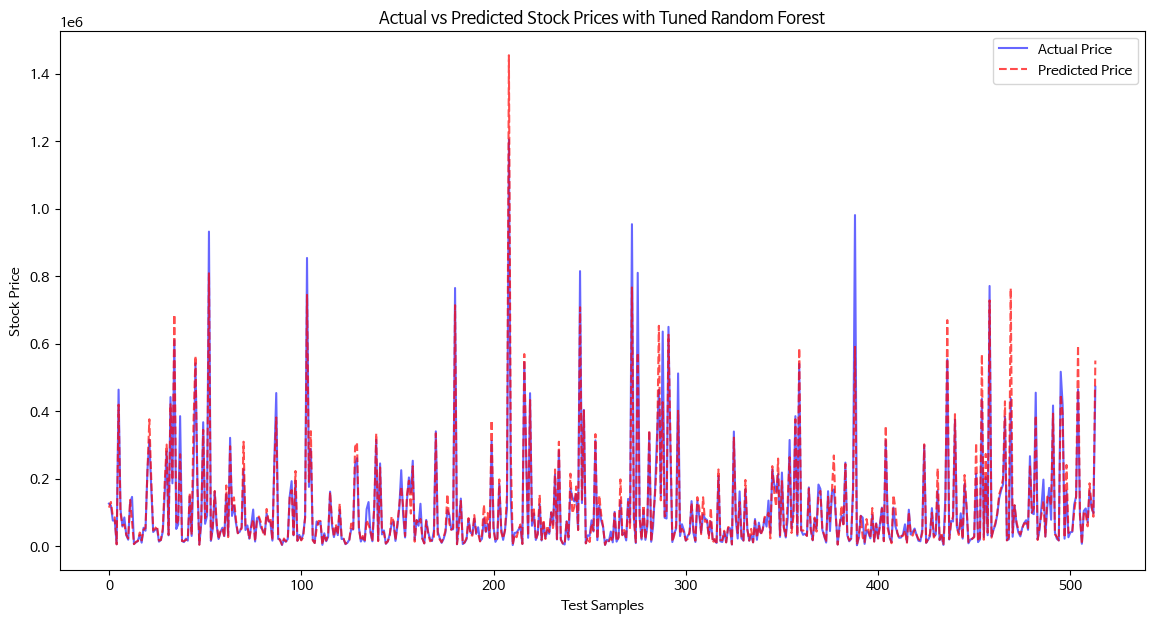

Root Mean Squared Error (RMSE): 40733.36537594096
Mean Absolute Error (MAE): 17824.062247081714
R^2 Score: 0.9321057043083588

Model Performance Summary:
RMSE: 40733.37
MAE: 17824.06
R^2 Score: 0.93


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: 이전 종가 데이터를 '이전 종가' 열로 추가하여 시간 종속성 반영
model_data['이전_종가'] = model_data.groupby('stock_code')['종가'].shift(1)  # 한 시점 전 종가

# 결측값 제거
model_data = model_data.dropna()

# Step 2: 설명 변수와 목표 변수 설정
features = ['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율', '이전_종가']
X = model_data[features]
y = model_data['종가']

# Step 3: 데이터 정규화 (StandardScaler로 매출액과 영업이익 정규화)
scaler = StandardScaler()
X[['매출액', '영업이익']] = scaler.fit_transform(X[['매출액', '영업이익']])

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: RandomForest 하이퍼파라미터 튜닝
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV로 튜닝
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적 모델 출력
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# Step 5: 최적 모델로 예측 및 평가
y_pred = best_rf.predict(X_test)

# 예측 결과와 실제 주가 비교 그래프
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label="Actual Price", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices with Tuned Random Forest")
plt.xlabel("Test Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R^2 Score 계산
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# 모델 성능 요약 출력
print("\nModel Performance Summary:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")


모델의 성능 지표를 요약하면 다음과 같습니다:

Root Mean Squared Error (RMSE): 40,733.37

예측값과 실제값 간의 차이를 나타내며, 값이 작을수록 모델의 예측 정확도가 높음을 의미합니다.
Mean Absolute Error (MAE): 17,824.06

예측값과 실제값의 절대적 차이 평균을 나타내며, 오차의 평균적인 크기를 보여줍니다.
R² Score: 0.93

모델의 설명력을 나타내며, 1에 가까울수록 모델이 실제 데이터를 잘 설명하고 있음을 의미합니다. 여기서 0.93이라는 높은 R² 값은 모델이 주가 변동의 93% 정도를 설명할 수 있다는 것을 의미합니다.

그러나 RMSE와 MAE가 여전히 만 단위의 값으로 나타나는 점에서 아주 세밀한 주가 예측은 아니므로, 더 정확한 예측을 원한다면 추가적인 개선이 필요할 수 있습니다.

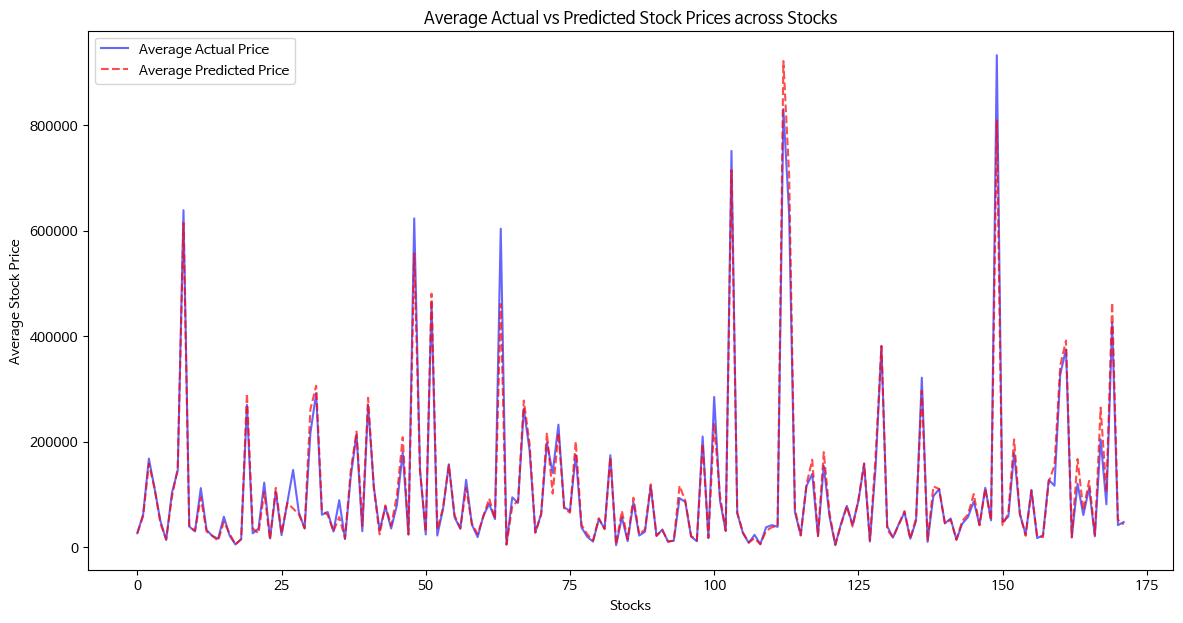

In [ ]:
# 종목별로 실제 주가와 예측 주가의 평균 계산
avg_actual_price = y_test.groupby(model_data['stock_code']).mean()
avg_pred_price = pd.DataFrame(y_pred, index=y_test.index).groupby(model_data['stock_code']).mean()

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(avg_actual_price.values, label="Average Actual Price", color="blue", alpha=0.6)
plt.plot(avg_pred_price.values, label="Average Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Average Actual vs Predicted Stock Prices across Stocks")
plt.xlabel("Stocks")
plt.ylabel("Average Stock Price")
plt.legend()
plt.show()


In [ ]:
# 테스트 데이터에 해당하는 인덱스만 추출
test_indices = y_test.index

# 테스트 데이터에 해당하는 model_data 부분 추출
model_data_test = model_data.loc[test_indices].copy()

# 예측 주가와 실제 주가의 차이 계산하여 오차 컬럼 추가
model_data_test['예측 종가'] = y_pred  # 예측 주가 추가
model_data_test['실제 종가'] = y_test.values  # 실제 주가 추가
model_data_test['예측 오차'] = abs(model_data_test['예측 종가'] - model_data_test['실제 종가'])

# 종목별 평균 예측 오차 계산
stock_accuracy = model_data_test.groupby('stock_code')['예측 오차'].mean()

# 평균 예측 오차 출력 (오차가 작은 상위 10개 종목 출력)
print(stock_accuracy.sort_values().head(10))


stock_code
1740      282.395000
175330    283.985000
32350     294.642500
10140     342.125000
47040     343.623333
3550      426.890000
30200     511.250000
36460     539.625000
6360      697.545000
73240     768.462000
Name: 예측 오차, dtype: float64


In [ ]:
# 테스트 데이터에 해당하는 인덱스만 추출
test_indices = y_test.index

# 테스트 데이터에 해당하는 model_data 부분 추출
model_data_test = model_data.loc[test_indices].copy()

# 예측 주가와 현재 주가 차이 계산하여 변동률 추가
model_data_test['예측 종가'] = y_pred  # 예측 주가 추가
model_data_test['실제 종가'] = y_test.values  # 실제 주가 추가
model_data_test['변동률'] = (model_data_test['예측 종가'] - model_data_test['실제 종가']) / model_data_test['실제 종가']

# 매수/매도 신호 생성 (예시로 변동률 5% 기준)
threshold = 0.05
model_data_test['신호'] = model_data_test['변동률'].apply(lambda x: '매수' if x > threshold else ('매도' if x < -threshold else '보유'))

# 테스트 데이터에 해당하는 인덱스를 사용해 날짜 추가
model_data_test['날짜'] = model_data.loc[test_indices, '날짜']

# 날짜, 실제 종가, 예측 종가, 변동률, 신호 확인
print(model_data_test[['날짜', '실제 종가', '예측 종가', '변동률', '신호']])



             날짜   실제 종가       예측 종가       변동률  신호
1807 2022-03-14  126500  114701.160 -0.093271  매도
1099 2023-08-14  120900  131524.030  0.087875  매수
1447 2023-08-14   76400   88198.695  0.154433  매수
602  2023-08-14   76500   85671.215  0.119885  매수
800  2024-03-19    6190    5946.255 -0.039377  보유
...         ...     ...         ...       ...  ..
3031 2022-08-12   71200   59265.475 -0.167620  매도
1666 2021-05-17  164500  186637.500  0.134574  매수
1063 2024-05-16  114700  122981.255  0.072199  매수
2093 2024-11-14   98000   87675.075 -0.105356  매도
2062 2021-11-15  472500  550165.000  0.164370  매수

[514 rows x 5 columns]



이제 2020년부터 2023년까지의 데이터를 학습 데이터로 사용하고, 2024년 데이터를 검증용 데이터셋으로 사용. 이 방식은 Holdout Validation 방식으로, 특정 연도의 데이터를 모델 성능 평가에 사용하여 모델이 최신 트렌드를 얼마나 잘 반영하는지 평가하는 데 유용하다.

<ipython-input-120-6fadf55ec4b9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['매출액', '영업이익']] = scaler.fit_transform(X_train[['매출액', '영업이익']])
<ipython-input-120-6fadf55ec4b9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['매출액', '영업이익']] = scaler.transform(X_test[['매출액', '영업이익']])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Model Performance on 2024 Data (Holdout Set):
Mean Absolute Error (MAE): 17817.83695527894
Root Mean Squared Error (RMSE): 36152.33320044896
Mean Absolute Percentage Error (MAPE): 17.92535672716405%
R^2 Score: 0.9116452482841175


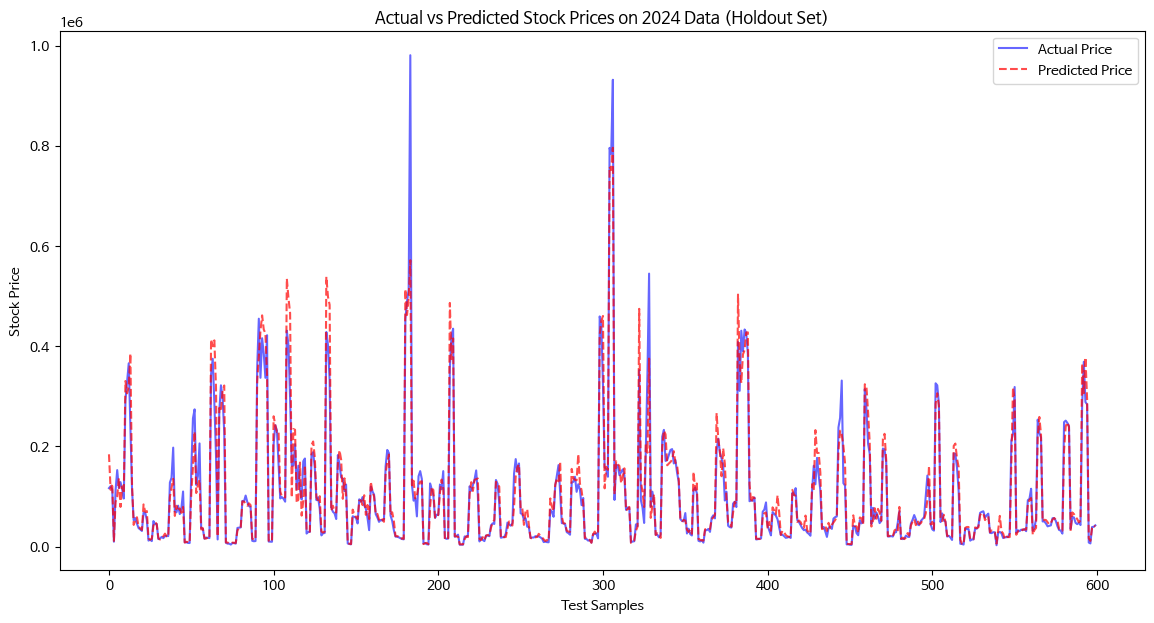

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기 및 날짜 형식 변환
model_data['날짜'] = pd.to_datetime(model_data['날짜'])

# 학습 데이터 (2020~2023)와 검증 데이터 (2024) 분리
train_data = model_data[model_data['날짜'] < '2024-01-01']
test_data = model_data[model_data['날짜'] >= '2024-01-01']

# 설명 변수와 목표 변수 설정
features = ['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율', '이전_종가']
X_train = train_data[features]
y_train = train_data['종가']
X_test = test_data[features]
y_test = test_data['종가']

# 데이터 정규화 (StandardScaler 사용)
scaler = StandardScaler()
X_train[['매출액', '영업이익']] = scaler.fit_transform(X_train[['매출액', '영업이익']])
X_test[['매출액', '영업이익']] = scaler.transform(X_test[['매출액', '영업이익']])

# 모델 학습
model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=20)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# 결과 출력
print("Model Performance on 2024 Data (Holdout Set):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R^2 Score: {r2}")

# 예측 결과와 실제 주가 비교 그래프
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label="Actual Price", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices on 2024 Data (Holdout Set)")
plt.xlabel("Test Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Feature Importances:
   Feature  Importance
7    이전_종가    0.966135
5    영업이익률    0.008890
6  자산_부채비율    0.006251
4  매출액_증가율    0.005954
2     자산총계    0.003720
1     영업이익    0.003633
0      매출액    0.003116
3     부채총계    0.002301


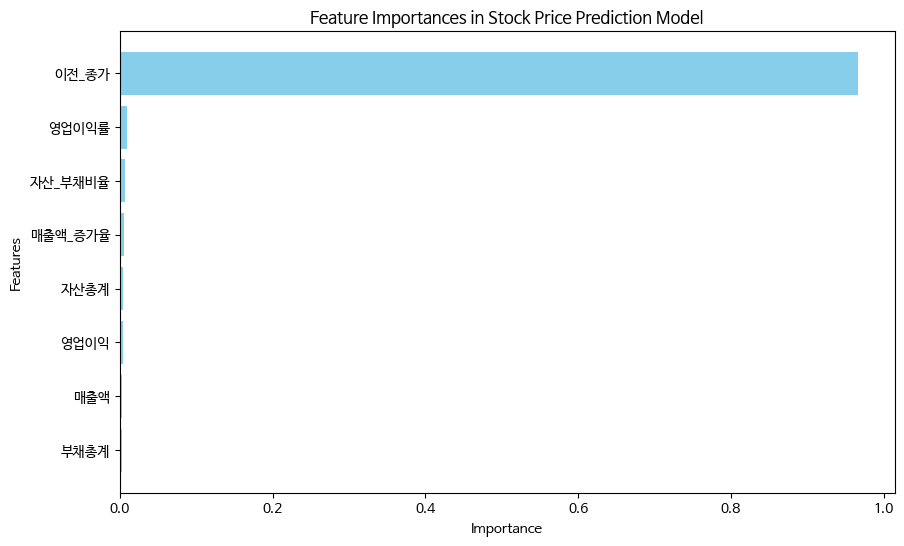

In [ ]:
import matplotlib.pyplot as plt

# 피처 중요도 추출
feature_importances = model.feature_importances_

# 설명 변수 이름과 중요도를 데이터프레임으로 구성
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print("Feature Importances:")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importances in Stock Price Prediction Model")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


**수정된 코드: 이전 종가 제외**

<ipython-input-122-37a00f612060>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['매출액', '영업이익']] = scaler.fit_transform(X[['매출액', '영업이익']])


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


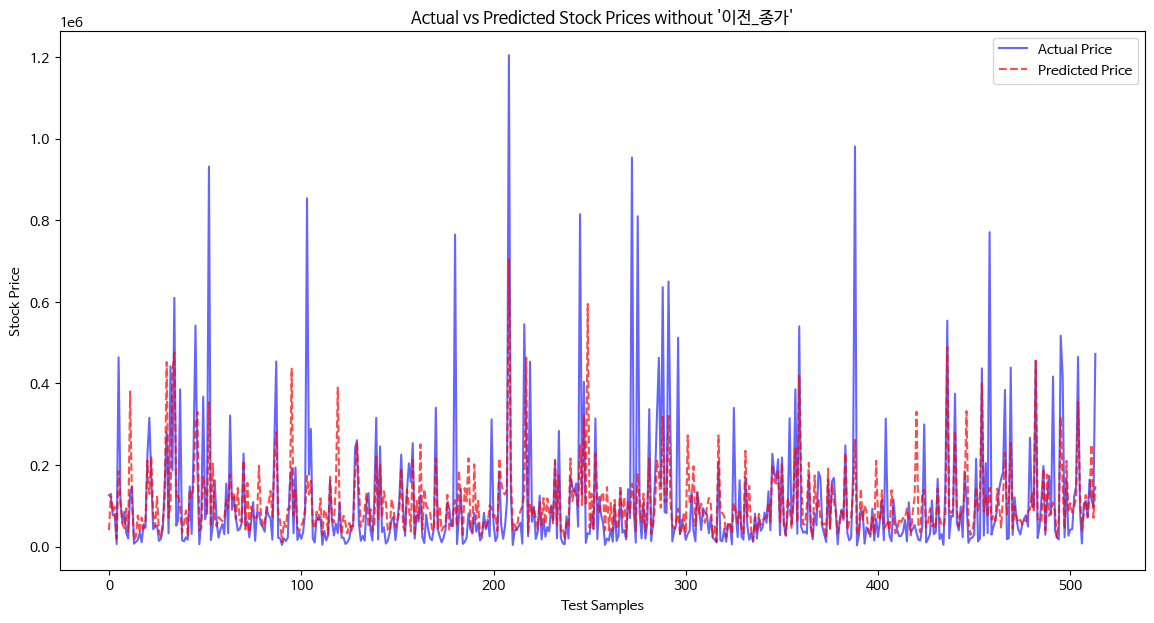


Model Performance Summary without '이전_종가':
RMSE: 122880.57
MAE: 65387.46
R^2 Score: 0.38


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: 설명 변수와 목표 변수 설정 (이전 종가 제외)
features = ['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율']  # '이전_종가' 제외
X = model_data[features]
y = model_data['종가']

# Step 2: 데이터 정규화 (StandardScaler로 매출액과 영업이익 정규화)
scaler = StandardScaler()
X[['매출액', '영업이익']] = scaler.fit_transform(X[['매출액', '영업이익']])

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: RandomForest 하이퍼파라미터 튜닝
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV로 튜닝
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적 모델 출력
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# Step 4: 최적 모델로 예측 및 평가
y_pred = best_rf.predict(X_test)

# 예측 결과와 실제 주가 비교 그래프
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label="Actual Price", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", color="red", linestyle="--", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices without '이전_종가'")
plt.xlabel("Test Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 모델 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Summary without '이전_종가':")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")


Index(['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율'], dtype='object')
Feature Importances:
   Feature  Importance
6  자산_부채비율    0.242130
2     자산총계    0.188089
3     부채총계    0.163902
1     영업이익    0.128215
5    영업이익률    0.117774
0      매출액    0.094207
4  매출액_증가율    0.065683


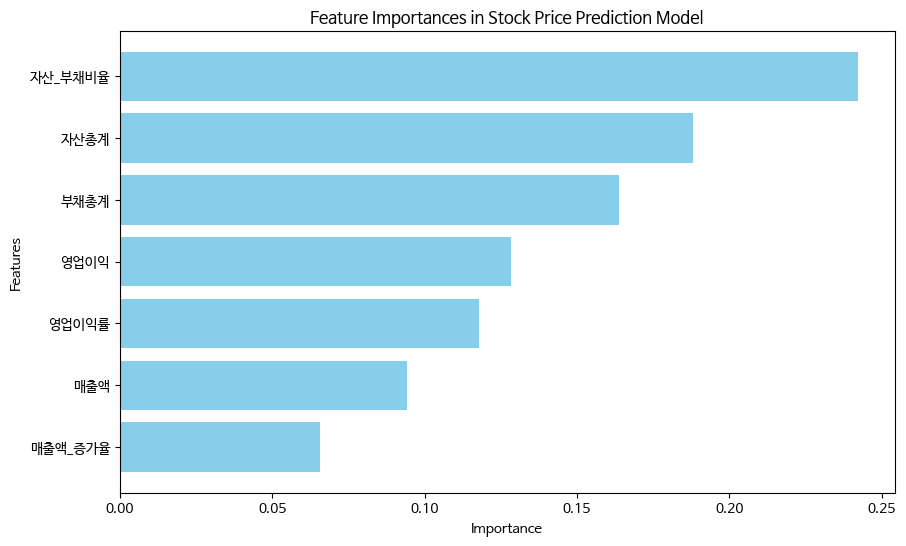

In [ ]:
# 모델에 사용된 실제 설명 변수를 확인합니다
print(X_train.columns)

# 'features' 리스트를 'X_train.columns'으로 재정의하여 일치시킵니다
features = X_train.columns.tolist()  # X_train의 컬럼을 리스트로 변환하여 features에 저장

# 이제 중요도 출력 및 시각화를 다시 실행
feature_importances = best_rf.feature_importances_

# 설명 변수 이름과 중요도를 데이터프레임으로 구성
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print("Feature Importances:")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importances in Stock Price Prediction Model")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


             날짜   실제 종가       예측 종가       변동률  신호
1807 2022-03-14  126500  114701.160 -0.093271  매도
1099 2023-08-14  120900  131524.030  0.087875  매수
1447 2023-08-14   76400   88198.695  0.154433  매수
602  2023-08-14   76500   85671.215  0.119885  매수
800  2024-03-19    6190    5946.255 -0.039377  보유
...         ...     ...         ...       ...  ..
3031 2022-08-12   71200   59265.475 -0.167620  매도
1666 2021-05-17  164500  186637.500  0.134574  매수
1063 2024-05-16  114700  122981.255  0.072199  매수
2093 2024-11-14   98000   87675.075 -0.105356  매도
2062 2021-11-15  472500  550165.000  0.164370  매수

[514 rows x 5 columns]
Confusion Matrix:
 [[179   7  87]
 [ 28   2  13]
 [122   4  72]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.54      0.66      0.59       273
           0       0.15      0.05      0.07        43
           1       0.42      0.36      0.39       198

    accuracy                           0.49       514
   macro avg  

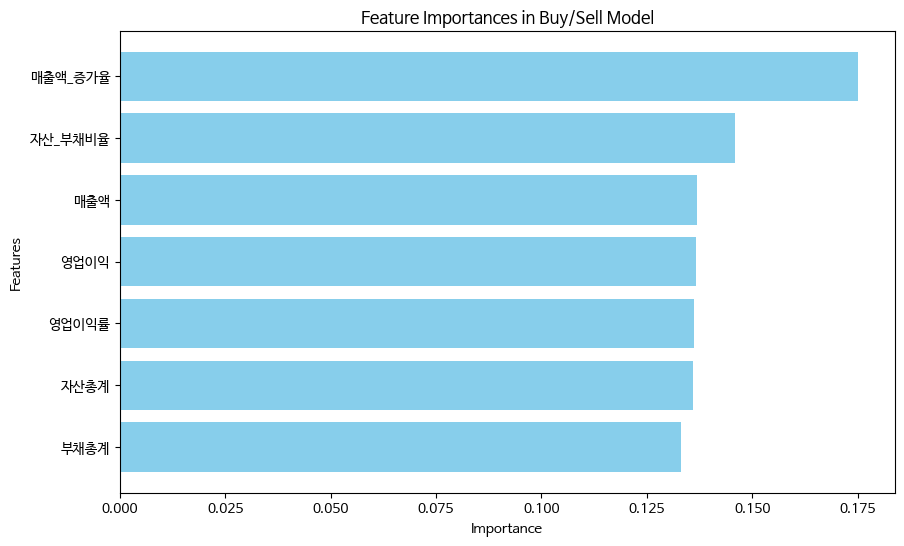

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 매수/매도 기준을 정해 '신호' 열 추가: 변동률 기준으로 매수/매도/보유를 결정
model_data['변동률'] = (model_data['종가'].shift(-1) - model_data['종가']) / model_data['종가']
model_data['신호'] = model_data['변동률'].apply(lambda x: 1 if x > 0.02 else (-1 if x < -0.02 else 0))  # 2% 이상 상승이면 매수(1), 2% 이상 하락이면 매도(-1), 그 외는 보유(0)

# 설명 변수(X)와 목표 변수(y) 설정
features = ['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율']
X = model_data[features]
y = model_data['신호']

# 테스트 데이터에 해당하는 인덱스를 사용해 날짜 추가
model_data_test['날짜'] = model_data.loc[test_indices, '날짜']

# 날짜, 실제 종가, 예측 종가, 변동률, 신호 확인
print(model_data_test[['날짜', '실제 종가', '예측 종가', '변동률', '신호']])

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 분류 모델 설정 및 학습 (RandomForestClassifier 사용)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = clf.predict(X_test)

# 평가 결과 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 주요 평가 지표
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importances in Buy/Sell Model")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


재무제표 지표는 일반적으로 분기마다 발표되기 때문에 주가와 같은 일일 또는 주간 데이터와 시간 간격이 맞지 않는 문제가 발생합니다. 주가 예측 모델에 주식의 일별 변동성을 반영하려면, 재무제표와 같은 저빈도 데이터에만 의존하는 것은 다소 제한적일 수 있습니다.

이러한 문제를 해결하기 위한 방법은 여러 가지가 있습니다:

 **1. 보간 (Interpolation) 또는 보존 (Forward Fill)**
재무제표 데이터의 공시 시점과 그 이후의 기간 동안 같은 값을 유지하거나, 보간법을 사용해 연속적인 값으로 확장하는 방식입니다.
예를 들어, 특정 분기 재무제표가 발표된 후 다음 분기까지 그 값을 그대로 유지하거나, 각 일에 대해 선형 보간을 적용할 수 있습니다.
다만, 이 방법은 정보가 실제로 업데이트되지 않으므로, 어느 정도의 한계가 있습니다.

**2. 주가 예측 시 일일 또는 고빈도 데이터 포함**
주가 예측 모델에 거래량, 이동평균, 변동성 지표 같은 고빈도 기술적 지표를 추가하여 예측 정확도를 높일 수 있습니다.
재무제표 지표는 기본적인 장기적인 성과를 반영하고, 기술적 지표는 단기적인 가격 변동성을 포착하는 데 유용합니다.

**3. 이벤트 기반 데이터 사용**
재무제표 외에도, 특정 경제 지표 (예: CPI, 금리 변화) 또는 CAPM과 같은 시장 요인을 추가하여 모델을 보완할 수 있습니다.
또한, 기업의 뉴스, 이벤트와 같은 비정형 데이터도 추가할 수 있지만, 이는 다소 복잡한 작업이 될 수 있습니다.

**4. 다중 시계열 모델링**
최근에는 LSTM이나 Transformer 같은 딥러닝 기반 모델을 사용하여 멀티 타임스케일 데이터를 함께 학습하는 방식이 있습니다. 이런 모델들은 저빈도 데이터(재무제표)와 고빈도 데이터(주가 및 기술적 지표)를 동시에 다룰 수 있습니다.

**5. 주기적인 재학습**
새로운 분기 데이터가 발표될 때마다 모델을 업데이트하거나 재학습하여 최신 데이터를 반영하게 할 수 있습니다.
결론적으로
단순히 3개월마다 갱신되는 재무제표 데이터만으로는 일일 주가 예측에 충분하지 않을 수 있습니다. 그러므로, 저빈도 재무 데이터와 고빈도 기술적 지표, 경제 지표를 통합하여 혼합 모델을 구축하는 것이 더 실용적입니다.



---



**이전 종가와 시간 종속성의 중요성**

이전 종가의 역할: 주가 예측 모델에서 가장 중요한 요소 중 하나로, 종가 자체가 종속성을 가지므로 미래 예측에 중요한 단서를 제공합니다.

시간 종속성의 역할: 주가는 일련의 흐름에 따라 변동하며, 최근 종가가 미래 종가를 예측하는 데 매우 유용한 정보가 될 수 있습니다. 시간 종속성을 고려한 예측은 단기적 변동을 반영하며 실제 시장에서 활용도가 높습니다.

*기술적 지표의 필요성: 기술적 지표는 시간 종속성을 기반으로 한 데이터 변화를 수치로 표현하여 추세, 변동성, 거래량 등과 같은 중요한 시장 정보를 모델에 제공할 수 있습니다. 예를 들어 이동 평균선, 볼린저 밴드 등을 추가하면 이전 주가만으로는 포착하기 어려운 변동 패턴을 반영할 수 있습니다.*

계산 주기 설정: 주기적으로 데이터가 업데이트되는 재무제표와 달리, 주가 및 기술적 지표는 일일로 갱신되므로 이를 반영하는 혼합형 피처 엔지니어링이 중요합니다.



**종목명 활용하여 산업별 분석**

In [ ]:

# 'stock_code'를 문자열 형식으로 변환하여 형식을 일치
model_data['stock_code'] = model_data['stock_code'].astype(str).str.zfill(6)
merged_kospi_200_corp_list['stock_code'] = merged_kospi_200_corp_list['stock_code'].astype(str).str.zfill(6)

# '종목명' 컬럼을 model_data에 추가하여 병합
model_data = pd.merge(model_data, merged_kospi_200_corp_list[['stock_code', '종목명']], on='stock_code', how='left')
print(model_data[['stock_code', '종목명']].head())  # 결합된 데이터 확인




  stock_code  종목명
0     282330  유통업
1     282330  유통업
2     282330  유통업
3     282330  유통업
4     282330  유통업


In [ ]:
model_data

,corp_name_x,stock_code,날짜,금융부채,금융상품관련순손익,기타포괄손익-공정가치측정금융자산,당기손익-공정가치측정금융자산,당기순이익,당기순이익(손실),매출액,...,파생상품자산,매출액_증가율,영업이익률,자산_부채비율,ROE,종가,이전_종가,변동률,신호,종목명
0,BGF리테일,282330,2021-03-17,0,0,0,0,1.227113e+11,"122,711,267,434",6.181269e+12,...,0,2.673361,2.624125,70.612481,17.609982,169500,140500.0,0.064897,1,유통업
1,BGF리테일,282330,2021-05-17,0,0,0,0,1.587135e+10,"15,871,350,141",1.501236e+12,...,0,-0.757131,1.440904,72.279761,2.364892,180500,169500.0,-0.041551,-1,유통업
2,BGF리테일,282330,2021-08-17,0,0,0,0,4.679361e+10,"46,793,613,196",1.700417e+12,...,0,0.132678,3.449022,71.953695,6.519380,173000,180500.0,-0.043353,-1,유통업
3,BGF리테일,282330,2021-11-15,0,0,0,0,4.931042e+10,"49,310,415,104",1.836557e+12,...,0,0.080063,3.783856,70.410308,6.429470,165500,173000.0,0.075529,1,유통업
4,BGF리테일,282330,2022-03-21,0,0,0,0,1.476429e+11,"147,642,852,239",6.781161e+12,...,0,2.692322,2.941114,68.828917,18.242842,178000,165500.0,0.140449,1,유통업
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,휠라홀딩스,081660,2023-08-14,0,0,0,0,3.719652e+10,"37,196,522,892",1.147006e+12,...,0,0.034644,8.015902,48.131661,1.384479,40100,35700.0,-0.026185,-1,유통업
2565,휠라홀딩스,081660,2023-11-14,0,0,0,0,-6.690001e+09,"-6,690,000,834",9.901923e+11,...,0,-0.136715,-0.418572,46.643279,-0.246641,39050,40100.0,0.002561,0,유통업
2566,휠라홀딩스,081660,2024-03-20,0,0,0,0,1.530568e+11,"153,056,827,039",4.006627e+12,...,0,3.046313,7.574788,48.718028,5.993018,39150,39050.0,0.006386,0,유통업
2567,휠라홀딩스,081660,2024-05-14,0,0,0,0,1.233298e+11,"123,329,753,831",1.182623e+12,...,0,-0.704833,13.804815,50.948009,4.656164,39400,39150.0,0.077411,1,유통업


**산업별 재무 특성 분석**

<ipython-input-167-489f9f42c296>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  industry_summary = industry_summary.applymap(lambda x: "{:,.2f}".format(x))  # 소수점 2자리로 반올림 후 천 단위 구분 기호 추가


                         매출액                   영업이익                    자산총계  \
종목명                                                                           
건설업     4,798,832,918,804.33     213,965,002,869.54   12,038,283,996,527.29   
기계      2,194,007,372,578.78     158,226,737,970.21    6,849,801,056,574.12   
기타금융    7,804,585,523,195.61     480,087,511,392.63   30,380,732,826,609.96   
기타제조업   2,533,643,864,396.53     594,687,993,297.93   12,256,455,303,175.40   
보험                      0.00                   0.00  133,265,677,908,303.80   
비금속광물     649,016,512,494.87      77,096,666,478.20    2,577,631,902,405.33   
서비스업    1,297,585,203,469.86     137,973,033,538.14    6,116,679,383,436.81   
섬유의복      813,255,925,908.12     127,494,343,973.04    1,425,746,894,594.92   
운수장비    9,169,958,928,055.29     524,107,634,573.59   30,107,828,823,671.44   
운수창고업   5,760,291,112,177.63     822,452,992,232.21   16,310,163,221,796.14   
유통업     5,404,297,529,985.26     201,320,505,780.88 

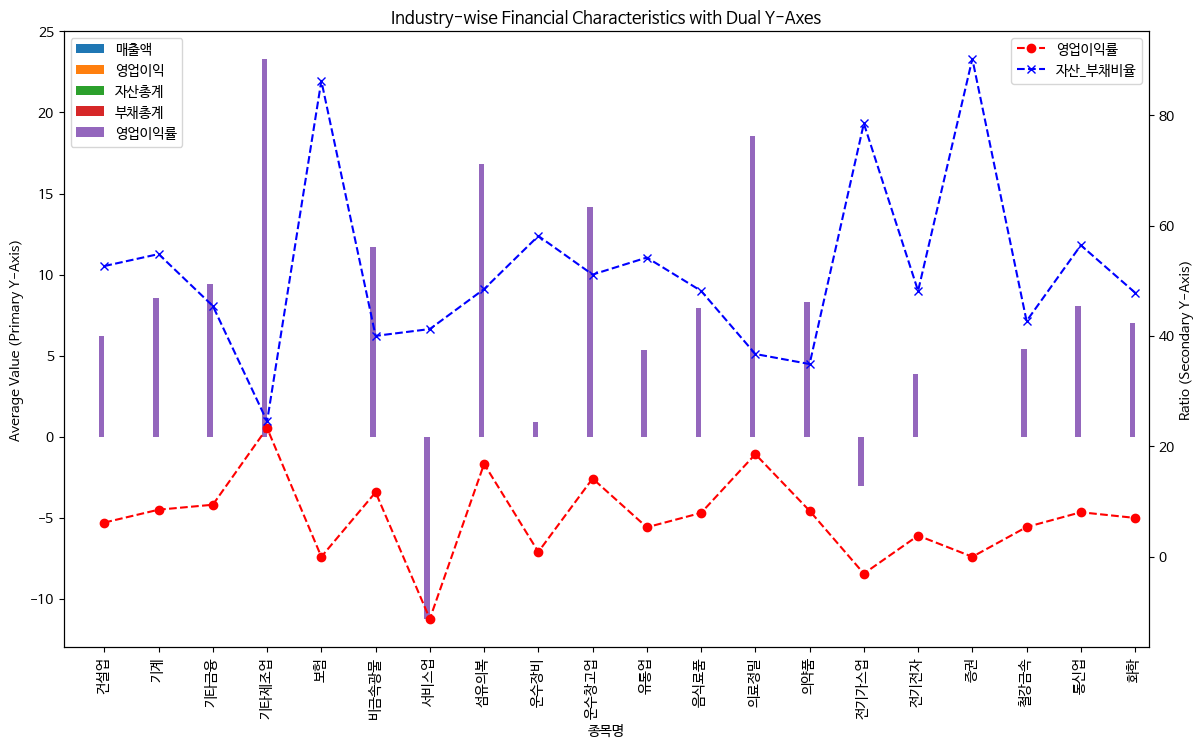

In [ ]:
# 산업별로 매출액, 영업이익, 자산총계 등 주요 재무 지표 평균값 집계
industry_summary = model_data.groupby('종목명')[['매출액', '영업이익', '자산총계', '부채총계', '영업이익률', '자산_부채비율']].mean()
# 숫자 포맷 조정
industry_summary = industry_summary.applymap(lambda x: "{:,.2f}".format(x))  # 소수점 2자리로 반올림 후 천 단위 구분 기호 추가

print(industry_summary)

# 산업별로 포함된 기업들 확인 (중복 제거)
industry_companies = model_data.groupby('종목명')['corp_name_x'].apply(lambda x: list(set(x)))  # 중복 제거

# 기업 목록 출력
print(industry_companies)

import matplotlib.pyplot as plt

# 산업별 재무 지표 시각화 (주 축)
fig, ax1 = plt.subplots(figsize=(14, 8))

# 주 축에 대한 시각화
industry_summary.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').plot(kind='bar', ax=ax1, position=1)

# 보조 축 설정
ax2 = ax1.twinx()

# 보조 축에 대한 시각화 (영업이익률, 자산_부채비율)
ax2.plot(industry_summary.index, industry_summary['영업이익률'].apply(pd.to_numeric, errors='coerce'), color='red', marker='o', label='영업이익률', linestyle='dashed')
ax2.plot(industry_summary.index, industry_summary['자산_부채비율'].apply(pd.to_numeric, errors='coerce'), color='blue', marker='x', label='자산_부채비율', linestyle='dashed')

# 제목과 레이블 설정
ax1.set_title("Industry-wise Financial Characteristics with Dual Y-Axes")
ax1.set_xlabel("종목명")
ax1.set_ylabel("Average Value (Primary Y-Axis)")
ax2.set_ylabel("Ratio (Secondary Y-Axis)")

# 범례 설정
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# X축의 종목명 레이블 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [ ]:
industry_summary

,매출액,영업이익,자산총계,부채총계,영업이익률,자산_부채비율
종목명,,,,,,
건설업,"4,798,832,918,804.33","213,965,002,869.54","12,038,283,996,527.29","7,165,534,266,806.99",6.20,52.66
기계,"2,194,007,372,578.78","158,226,737,970.21","6,849,801,056,574.12","4,184,071,224,145.62",8.53,54.83
기타금융,"7,804,585,523,195.61","480,087,511,392.63","30,380,732,826,609.96","18,580,251,606,213.89",9.43,45.43
기타제조업,"2,533,643,864,396.53","594,687,993,297.93","12,256,455,303,175.40","3,025,488,684,658.80",23.31,24.54
보험,0.00,0.00,"133,265,677,908,303.80","115,858,538,043,679.20",0.00,86.21
비금속광물,"649,016,512,494.87","77,096,666,478.20","2,577,631,902,405.33","1,033,416,009,715.27",11.69,40.01
서비스업,"1,297,585,203,469.86","137,973,033,538.14","6,116,679,383,436.81","2,239,307,329,794.21",-11.24,41.25
섬유의복,"813,255,925,908.12","127,494,343,973.04","1,425,746,894,594.92","667,196,613,999.42",16.82,48.49
운수장비,"9,169,958,928,055.29","524,107,634,573.59","30,107,828,823,671.44","17,520,653,727,437.97",0.89,58.11


**산업별 피처 중요도 분석**

Feature Importances by Industry:
              유통업      기타금융     운수창고업      음식료품        보험        화학       건설업  \
매출액      0.139827  0.135479  0.132151  0.133290  0.000000  0.138170  0.171603   
영업이익     0.152314  0.127953  0.146605  0.146408  0.000000  0.140928  0.196759   
자산총계     0.136409  0.137986  0.117996  0.139858  0.273408  0.126978  0.118801   
부채총계     0.134829  0.138810  0.150414  0.125695  0.284644  0.122208  0.118194   
매출액_증가율  0.157104  0.192414  0.168078  0.176060  0.000000  0.184744  0.129667   
영업이익률    0.144425  0.126565  0.120445  0.135239  0.000000  0.146036  0.154567   
자산_부채비율  0.135091  0.140793  0.164312  0.143450  0.441948  0.140936  0.110409   

             섬유의복      서비스업      운수장비        기계      전기전자      철강금속       통신업  \
매출액      0.197496  0.134403  0.130030  0.148606  0.137855  0.139000  0.191475   
영업이익     0.121856  0.137712  0.133644  0.114759  0.144548  0.152950  0.177368   
자산총계     0.173951  0.152086  0.137670  0.140156  0.137053  0.134107  0.1249

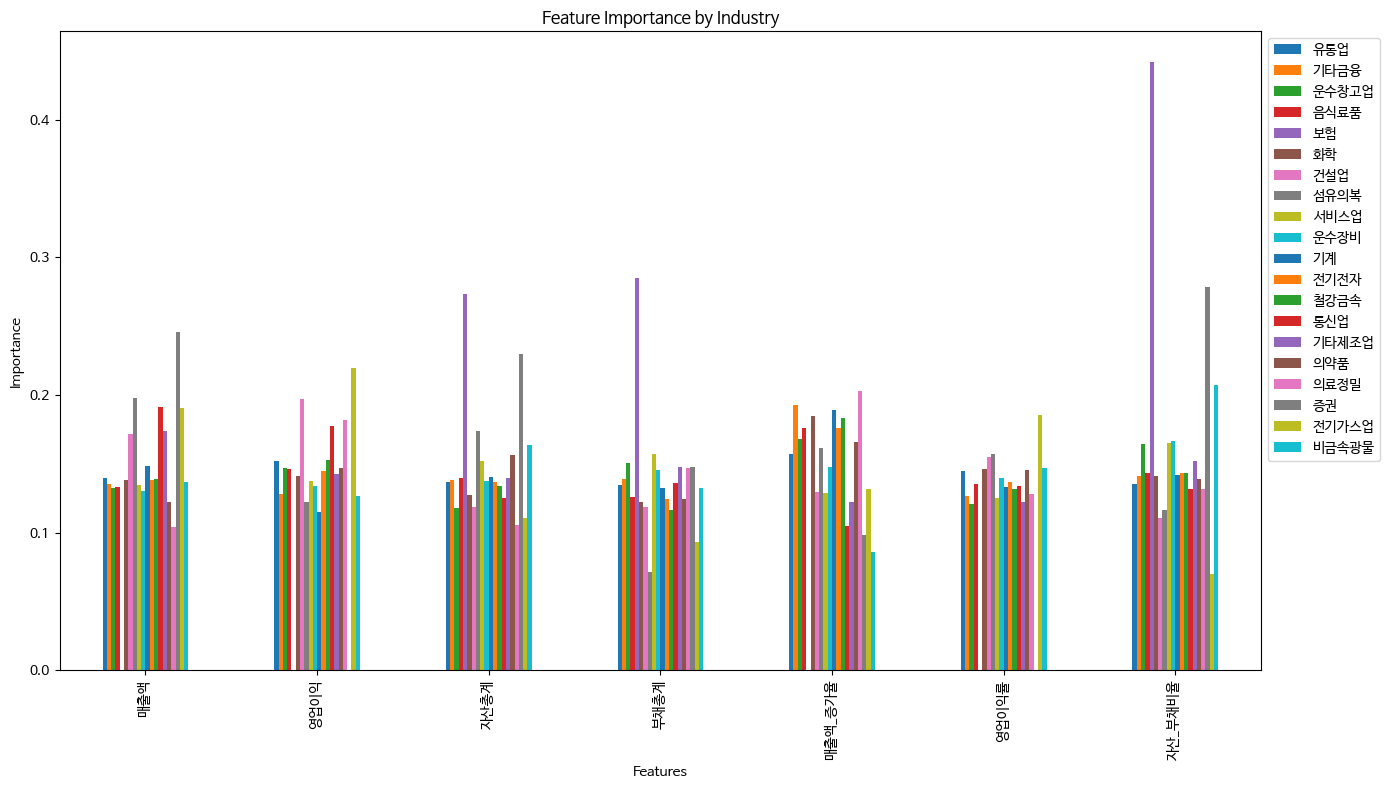

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 산업별로 모델 학습 후 피처 중요도 계산
feature_importances_by_industry = {}

for industry in model_data['종목명'].unique():
    industry_data = model_data[model_data['종목명'] == industry]
    X = industry_data[['매출액', '영업이익', '자산총계', '부채총계', '매출액_증가율', '영업이익률', '자산_부채비율']]
    y = industry_data['신호']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    feature_importances_by_industry[industry] = clf.feature_importances_

# 산업별 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame(feature_importances_by_industry, index=X.columns)
print("Feature Importances by Industry:")
print(importance_df)

# 산업별 피처 중요도 시각화
importance_df.plot(kind='bar', figsize=(14, 8))

# 그래프 제목 및 축 이름 설정
plt.title("Feature Importance by Industry")
plt.xlabel("Features")
plt.ylabel("Importance")

# 범례를 그래프 밖으로 이동
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# 그래프 표시
plt.tight_layout()  # 레이아웃을 자동으로 조정
plt.show()



**산업별 가중치를 반영한 모델링**

예시코드이며 더 공부가 필요함

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
RMSE: 128355.90385811764
MAE: 71026.6636169594
R^2 Score: 0.3258377965289885


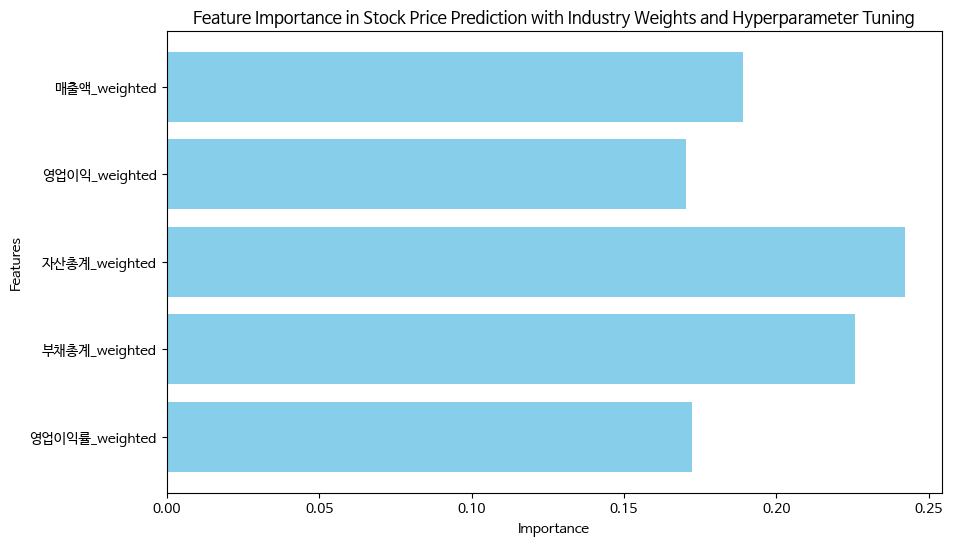

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 산업별 가중치 딕셔너리
industry_weights = {
    '건설업': {'매출액': 0.3, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.1},
    '기계': {'매출액': 0.25, '영업이익': 0.25, '자산총계': 0.25, '부채총계': 0.15, '영업이익률': 0.1},
    '기타금융': {'매출액': 0.2, '영업이익': 0.25, '자산총계': 0.3, '부채총계': 0.15, '영업이익률': 0.1},
    '기타제조업': {'매출액': 0.25, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '보험': {'매출액': 0.1, '영업이익': 0.2, '자산총계': 0.5, '부채총계': 0.1, '영업이익률': 0.1},
    '비금속광물': {'매출액': 0.25, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.2, '영업이익률': 0.1},
    '서비스업': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.15},
    '섬유의복': {'매출액': 0.3, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.1},
    '운수장비': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '운수창고업': {'매출액': 0.3, '영업이익': 0.2, '자산총계': 0.25, '부채총계': 0.15, '영업이익률': 0.1},
    '유통업': {'매출액': 0.25, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '음식료품': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '의료정밀': {'매출액': 0.3, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.1},
    '의약품': {'매출액': 0.3, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.1},
    '전기가스업': {'매출액': 0.2, '영업이익': 0.1, '자산총계': 0.5, '부채총계': 0.1, '영업이익률': 0.1},
    '전기전자': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.1, '영업이익률': 0.15},
    '증권': {'매출액': 0.1, '영업이익': 0.2, '자산총계': 0.5, '부채총계': 0.1, '영업이익률': 0.1},
    '철강금속': {'매출액': 0.25, '영업이익': 0.3, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '통신업': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
    '화학': {'매출액': 0.3, '영업이익': 0.25, '자산총계': 0.2, '부채총계': 0.15, '영업이익률': 0.1},
}

# 산업별로 데이터를 준비
model_data['industry_weight'] = model_data['종목명'].map(industry_weights)

# 각 산업별로 가중치를 곱한 새로운 특성 생성 (예: 매출액에 산업별 가중치 곱하기)
for feature in ['매출액', '영업이익', '자산총계', '부채총계', '영업이익률']:
    model_data[feature + '_weighted'] = model_data[feature] * model_data['industry_weight'].apply(lambda x: x.get(feature, 1))

# 설명 변수와 목표 변수 설정
features = ['매출액_weighted', '영업이익_weighted', '자산총계_weighted', '부채총계_weighted', '영업이익률_weighted']
X = model_data[features]
y = model_data['종가']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 튜닝을 위한 파라미터 설정
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV로 튜닝
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적 모델 출력
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# 최적 모델로 예측 및 평가
y_pred = best_rf.predict(X_test)

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

# 피처 중요도 시각화
feature_importances = best_rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Price Prediction with Industry Weights and Hyperparameter Tuning')
plt.gca().invert_yaxis()
plt.show()

